## Boosting

In [1]:
library(rpart)
library(randomForest)
library(rpart.plot)
library(xgboost)
library(gbm)
wals <- read.csv('wals.csv')
binwals <- read.csv('binarized-wals.csv')

colnames(wals) <- sub("(X[0-9]+[A-Z])(.*)","\\1",colnames(wals))
binwals$X <- NULL

randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.
Loading required package: survival
Loading required package: lattice
Loading required package: splines
Loading required package: parallel
Loaded gbm 2.1.3


In [13]:
chunk_wals <- function(cols,supp) {
    cols <- unlist(lapply(cols,function(f){paste('X',f,sep="")}))
    wals[rowSums(binwals[,cols]) >= length(cols),c(cols,supp)]
}
exampletree <- function(langs,wals_chunk,cp=0.01,minsplit=8) {
    dat <- wals_chunk[wals_chunk$family %in% langs,]
    dat$family <-  droplevels(dat$family)
    dat <- lapply(dat,as.factor)
    tree <- rpart(family ~ ., data = dat,control=c(minsplit=minsplit,cp=cp),method='class')
    tree
}
exampleforest <- function(langs,wals_chunk) {
    dat <- wals_chunk[wals_chunk$family %in% langs,]
    dat$family <- droplevels(dat$family)
    dat <- lapply(dat,as.factor)
    forest <- randomForest(family ~ ., data=dat, importance=TRUE)
    forest
}
one_vs_others <- function(family,chunk) {
    tar <- chunk[chunk$family == family,]
    others <- chunk[chunk$family != family,]
    others <- others[sample(nrow(others),nrow(tar)),]
    others$family <- 0
    tar$family <- 1
    rbind(tar,others)
}

xify <- function(cols) {
    unlist(lapply(cols,function(f){paste('X',f,sep="")}))
}

In [14]:
g = c('143A','81A','89A','97A')
chunk <- chunk_wals(g,'family')
bchunk <- one_vs_others('Niger-Congo',chunk)
t <- gbm(family ~ ., data = bchunk,distribution="bernoulli")

,var,rel.inf
X81A,X81A,87.52251
X89A,X89A,12.47749
X143A,X143A,0.00000
X97A,X97A,0.00000


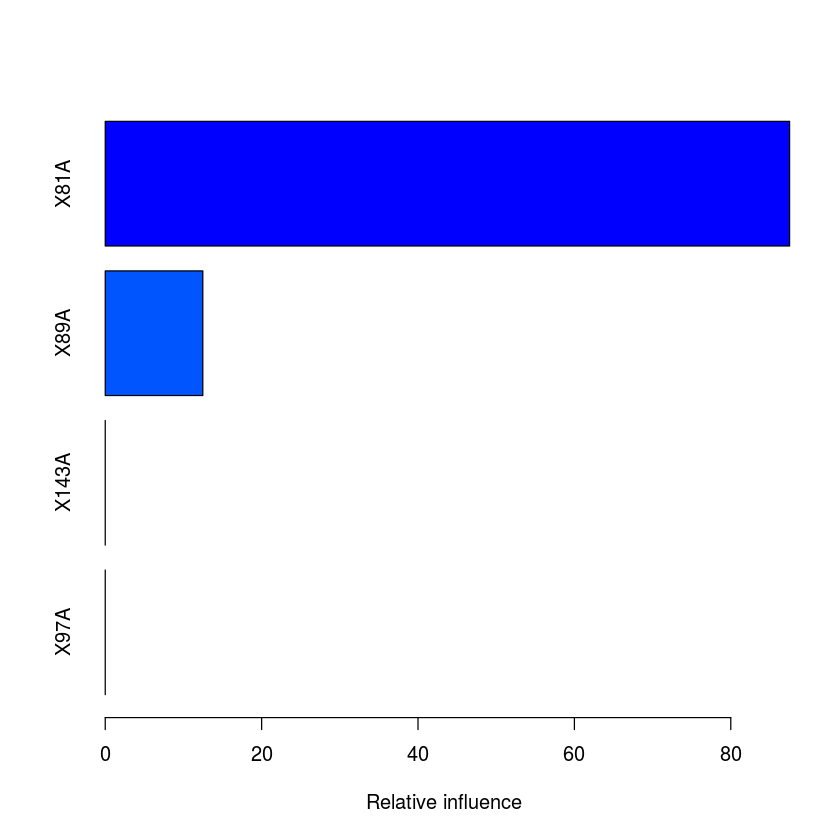

In [47]:
summary(t)

In [69]:
test <- wals[wals$X81A != "",xify(g)]

In [70]:
x <- predict(t, newdata=test, type="response",n.trees=100)